In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext lab_black
import seaborn as sns
import re

plt.style.use(["ggplot"])
plt.rcParams["figure.figsize"] = [20, 6]
from scipy import stats


# import statsmodels.api as sm
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import sklearn.model_selection as skms
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn import tree
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.ensemble import (
    RandomTreesEmbedding,
    RandomForestClassifier,
    GradientBoostingClassifier,
)
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from dfply import select
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

In [ ]:
%cd ''

In [2]:
%cd "//AEBS199101/WallingNR/My Documents/HRDevelopment/Other"

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
\\AEBS199101\WallingNR\My Documents\HRDevelopment\Other


In [25]:
# define Counts
def counts(x):
    uni, cnt = np.unique(x, return_counts=True)
    data = np.array([uni, cnt]).T
    return pd.DataFrame(
        data=data[0:, 0:], index=data[0:, 0], columns=["Factors", "Count"]
    )


def ConfM(x):
    y = pd.DataFrame(
        x, columns=["Predicted No", "Predicted Yes"], index=["True No", "True Yes"]
    )
    return y


def replace_stupidname(df):
    df.columns = df.columns.str.replace("`", "")
    return df


def replace_dax_name(df):
    df.columns = df.columns.str.extract("\[(.*)\]", expand=False)
    return df


# Class to make calling df names easier
class Columns:
    import threading

    def __init__(self, df):
        self._df = df
        self._update()

    def _update(self):
        self.__dict__.update({d: d for d in self._df.columns.tolist()})
        # threading.Timer(3, self._update).start()


# Function to aggregate data quickly looking at standardization
def normalize_by_group(df, by, zonly=False):
    groups = df.groupby(by)
    # computes group-wise mean/std,
    # then auto broadcasts to size of group chunk
    mean = groups.transform(np.mean)
    std = groups.transform(np.std)
    z = ((df[mean.columns] - mean) / std).fillna(0).add_prefix("z").fillna(0)
    avg = mean.add_prefix("avg")
    s = std.add_prefix("std")
    mn = groups.transform(np.min).add_prefix("min")
    mx = groups.transform(np.max).add_prefix("max")
    if not zonly:
        return pd.concat([avg, z, s, mn, mx], 1, sort=False).replace(
            [np.inf, -np.inf], 0
        )
    else:
        return z.replace([np.inf, -np.inf], 0)

In [17]:
credit = pd.read_csv("default of credit card clients.csv", skiprows=1).drop("ID", 1)

In [18]:
credit.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [112]:
y = np.ravel(credit[["default payment next month"]])
X = credit.drop("default payment next month", 1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit only to the training data
X = scaler.fit_transform(X.values)

# StandardScaler(copy=True, with_mean=True, with_std=True)

# # Now apply the transformations to the data:
# X = scaler.transform(X).pd

In [95]:
X
#Testing pca 
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(X)
print(pca.explained_variance_ratio_)

X_pca = pca.transform(X)

[0.28448215 0.17818817 0.06743229 0.06401128 0.04456486]


In [113]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2)

In [114]:
# oversampling
sm = SMOTE(sampling_strategy=1, random_state=43)
X_train, y_train = sm.fit_resample(X_train1, y_train1)

In [115]:
counts(y_train)

,Factors,Count
0,0,18733
1,1,18733


Confusion Matrix :
          Predicted No  Predicted Yes
True No           4431            200
True Yes           936            433
Accuracy Score : 0.8106666666666666
Report : 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4631
           1       0.68      0.32      0.43      1369

    accuracy                           0.81      6000
   macro avg       0.75      0.64      0.66      6000
weighted avg       0.79      0.81      0.78      6000



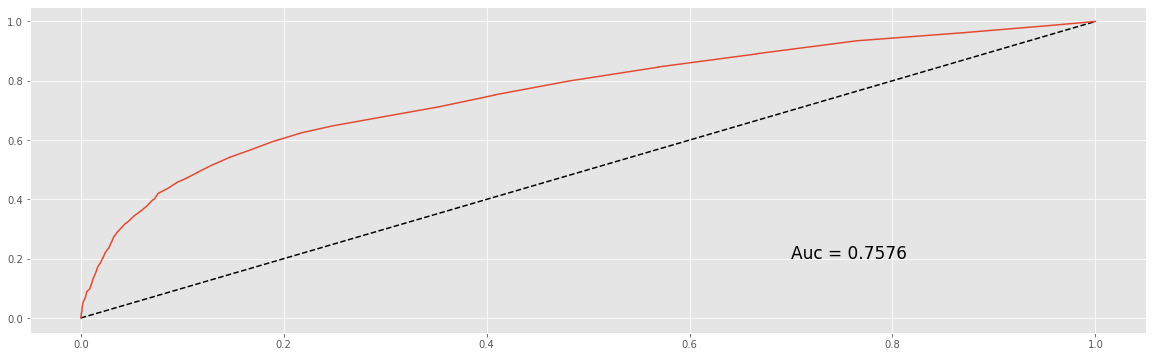

In [116]:
# The random forest model by itself
n_estimator = 50
rf = RandomForestClassifier(
    n_estimators=n_estimator, bootstrap=True, class_weight={1: 50, 0: 1}
)
rf.fit(X_train1, np.ravel(y_train1))
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
auc_rf = metrics.auc(fpr_rf, tpr_rf)
y_predic_rf = rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_predic_rf)
print("Confusion Matrix :")
print(ConfM(cm_rf))
print("Accuracy Score :", accuracy_score(y_test, y_predic_rf))
print("Report : ")
print(classification_report(y_test, y_predic_rf))
plt.figure(1)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr_rf, tpr_rf, label="RF")
plt.text(x=0.7, y=0.2, s="Auc = " + auc_rf.round(4).astype(str), size=17)
plt.show()

Confusion Matrix :
          Predicted No  Predicted Yes
True No           4316            315
True Yes           850            519
Accuracy Score : 0.8058333333333333
Report : 
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4631
           1       0.62      0.38      0.47      1369

    accuracy                           0.81      6000
   macro avg       0.73      0.66      0.68      6000
weighted avg       0.79      0.81      0.79      6000



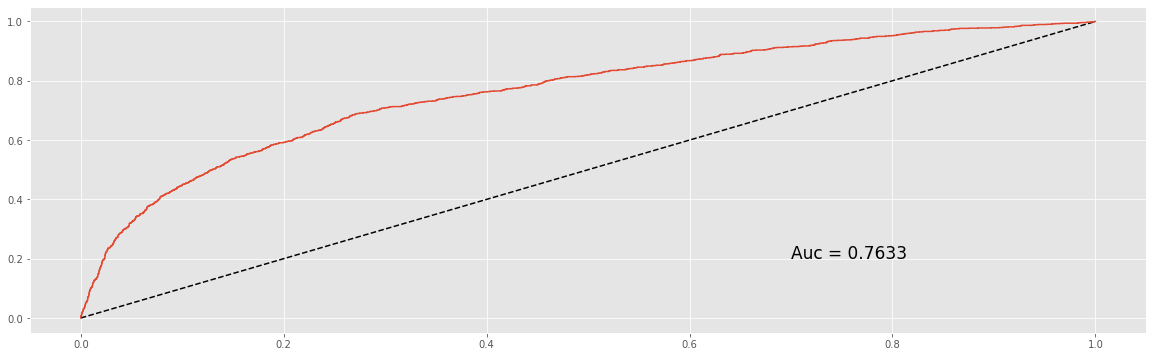

In [147]:
nn = MLPClassifier(
    solver="lbfgs", alpha=10, hidden_layer_sizes=(50, 50, 50), random_state=1
)

nn.fit(X_train1, y_train1)
y_pred_nn = nn.predict_proba(X_test)[:, 1]
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn)
auc_nn = metrics.auc(fpr_nn, tpr_nn)
y_predic_nn = nn.predict(X_test)
cm_nn = confusion_matrix(y_test, y_predic_nn)
print("Confusion Matrix :")
print(ConfM(cm_nn))
print("Accuracy Score :", accuracy_score(y_test, y_predic_nn))
print("Report : ")
print(classification_report(y_test, y_predic_nn))
plt.figure(1)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr_nn, tpr_nn, label="RF")
plt.text(x=0.7, y=0.2, s="Auc = " + auc_nn.round(4).astype(str), size=17)
plt.show()

In [143]:
nn.get_params()

{'activation': 'relu',
 'alpha': 10,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (50, 50, 50),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

Confusion Matrix :
          Predicted No  Predicted Yes
True No           4515            116
True Yes          1049            320
Accuracy Score : 0.8058333333333333
Report : 
              precision    recall  f1-score   support

           0       0.81      0.97      0.89      4631
           1       0.73      0.23      0.35      1369

    accuracy                           0.81      6000
   macro avg       0.77      0.60      0.62      6000
weighted avg       0.79      0.81      0.76      6000



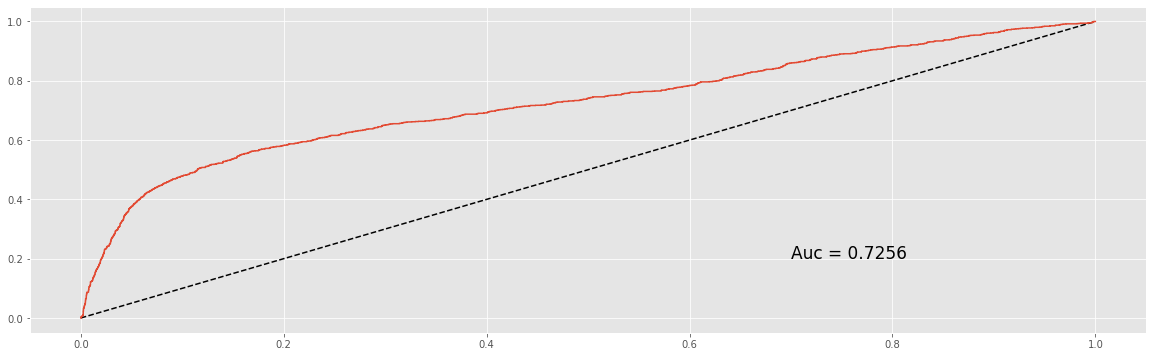

In [139]:
from sklearn import linear_model

las = linear_model.LogisticRegression(penalty="l1", solver="liblinear")
las.fit(X_train1, y_train1)
y_pred_las = las.predict_proba(X_test)[:, 1]
fpr_las, tpr_las, _ = roc_curve(y_test, y_pred_las)
auc_las = metrics.auc(fpr_las, tpr_las)
y_predic_las = las.predict(X_test)
cm_las = confusion_matrix(y_test, y_predic_las)
print("Confusion Matrix :")
print(ConfM(cm_las))
print("Accuracy Score :", accuracy_score(y_test, y_predic_las))
print("Report : ")
print(classification_report(y_test, y_predic_las))
plt.figure(1)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr_las, tpr_las, label="RF")
plt.text(x=0.7, y=0.2, s="Auc = " + auc_las.round(4).astype(str), size=17)
plt.show()

In [134]:
from sklearn.svm import l1_min_c


cs = l1_min_c(X_train1, y_train1, loss="log") * np.logspace(-1, 3, 16)
cs

array([1.48522204e-05, 2.74446725e-05, 5.07136325e-05, 9.37111755e-05,
       1.73164177e-04, 3.19981389e-04, 5.91277544e-04, 1.09259209e-03,
       2.01894607e-03, 3.73070909e-03, 6.89379004e-03, 1.27386885e-02,
       2.35391830e-02, 4.34968746e-02, 8.03756909e-02, 1.48522204e-01])

C:\Program Files\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Program Files\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Program Files\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Program Files\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


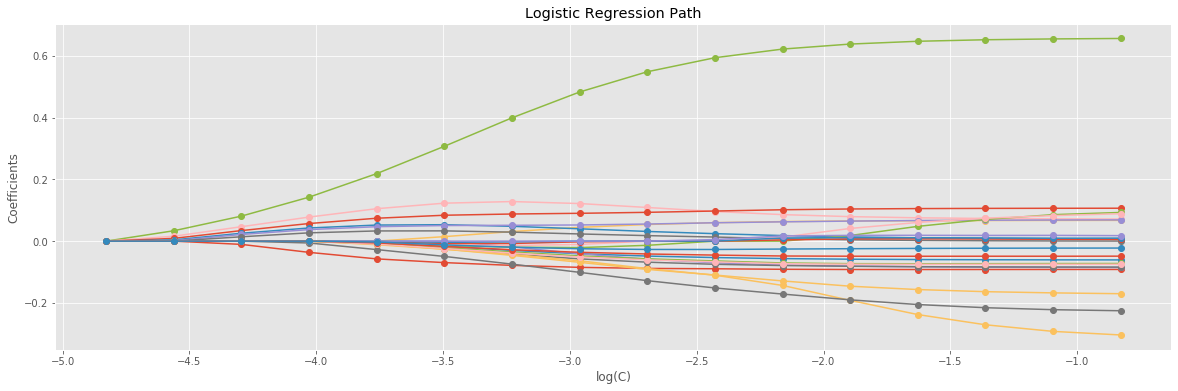

In [135]:
coefs_ = []
for c in cs:
    las.set_params(C=c)
    las.fit(X_train1, y_train1)
    coefs_.append(las.coef_.ravel().copy())


coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_, marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.show()

C:\Program Files\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Program Files\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix :
          Predicted No  Predicted Yes
True No           4498            196
True Yes           863            443
Accuracy Score : 0.8235
Report : 
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      4694
           1       0.69      0.34      0.46      1306

    accuracy                           0.82      6000
   macro avg       0.77      0.65      0.68      6000
weighted avg       0.81      0.82      0.80      6000



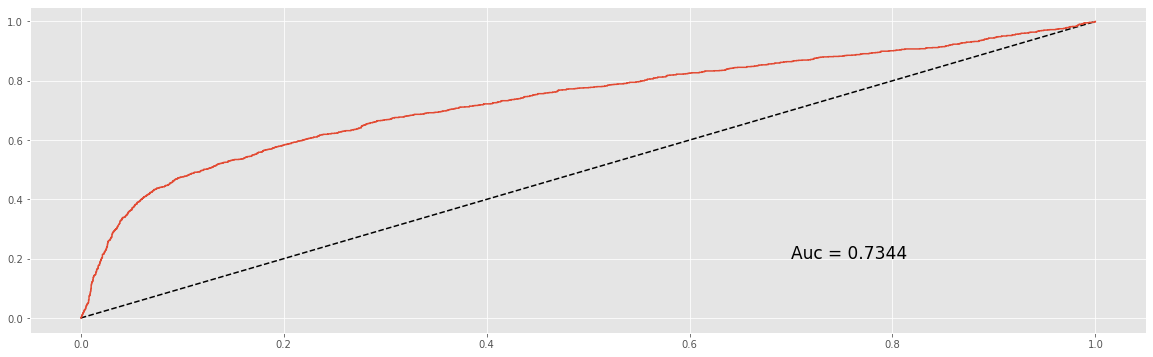

In [91]:
from sklearn import svm

# data set may be too big for Support Vecotors


sv = svm.SVC(gamma="scale", probability=True)
sv.fit(X_train1, y_train1)

y_pred_sv = sv.predict_proba(X_test)[:, 1]
fpr_sv, tpr_sv, _ = roc_curve(y_test, y_pred_sv)
auc_sv = metrics.auc(fpr_sv, tpr_sv)
y_predic_sv = sv.predict(X_test)
cm_sv = confusion_matrix(y_test, y_predic_sv)
print("Confusion Matrix :")
print(ConfM(cm_sv))
print("Accuracy Score :", accuracy_score(y_test, y_predic_sv))
print("Report : ")
print(classification_report(y_test, y_predic_sv))
plt.figure(1)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr_sv, tpr_sv, label="RF")
plt.text(x=0.7, y=0.2, s="Auc = " + auc_sv.round(4).astype(str), size=17)
plt.show()